In [1]:
trial_number_ml = "001"
random_state_init = 42

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 14:30:36,555] A new study created in memory with name: no-name-3d2f0a98-437c-4997-8f64-699e41c6e43b


[I 2024-05-01 14:30:51,973] Trial 1 finished with value: 0.8147888540111135 and parameters: {'n_estimators': 102, 'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.8147888540111135.


[I 2024-05-01 14:31:06,231] Trial 0 finished with value: 0.848261359826898 and parameters: {'n_estimators': 183, 'max_depth': 73, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.848261359826898.


[I 2024-05-01 14:31:25,303] Trial 4 finished with value: 0.8351898129806277 and parameters: {'n_estimators': 231, 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.848261359826898.


[I 2024-05-01 14:31:59,479] Trial 5 finished with value: 0.869297229756499 and parameters: {'n_estimators': 287, 'max_depth': 72, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.869297229756499.


[I 2024-05-01 14:32:21,420] Trial 3 finished with value: 0.8431602312091752 and parameters: {'n_estimators': 675, 'max_depth': 88, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.869297229756499.


[I 2024-05-01 14:32:26,191] Trial 7 pruned. 


[I 2024-05-01 14:32:37,543] Trial 9 pruned. 


[I 2024-05-01 14:32:45,354] Trial 8 finished with value: 0.8463464683712756 and parameters: {'n_estimators': 163, 'max_depth': 77, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 5 with value: 0.869297229756499.


[I 2024-05-01 14:32:49,571] Trial 2 finished with value: 0.8571866841394163 and parameters: {'n_estimators': 874, 'max_depth': 38, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 5 with value: 0.869297229756499.


[I 2024-05-01 14:33:10,333] Trial 6 finished with value: 0.8339159276303091 and parameters: {'n_estimators': 759, 'max_depth': 47, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 5 with value: 0.869297229756499.


[I 2024-05-01 14:33:19,584] Trial 12 finished with value: 0.8402873860969737 and parameters: {'n_estimators': 207, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 5 with value: 0.869297229756499.


[I 2024-05-01 14:34:02,733] Trial 10 finished with value: 0.8632457664137181 and parameters: {'n_estimators': 557, 'max_depth': 70, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 5 with value: 0.869297229756499.


[I 2024-05-01 14:34:07,158] Trial 11 finished with value: 0.861331382886864 and parameters: {'n_estimators': 540, 'max_depth': 72, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 5 with value: 0.869297229756499.


[I 2024-05-01 14:35:02,027] Trial 13 finished with value: 0.8763168053312202 and parameters: {'n_estimators': 577, 'max_depth': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.8763168053312202.


[I 2024-05-01 14:35:20,825] Trial 16 finished with value: 0.875036824835685 and parameters: {'n_estimators': 358, 'max_depth': 99, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.8763168053312202.


[I 2024-05-01 14:35:57,803] Trial 15 finished with value: 0.8731254888814393 and parameters: {'n_estimators': 567, 'max_depth': 99, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.8763168053312202.


[I 2024-05-01 14:36:14,364] Trial 19 pruned. 


[I 2024-05-01 14:36:16,433] Trial 14 finished with value: 0.8766301973811192 and parameters: {'n_estimators': 891, 'max_depth': 60, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8766301973811192.


[I 2024-05-01 14:36:53,270] Trial 18 finished with value: 0.8750388565507574 and parameters: {'n_estimators': 426, 'max_depth': 92, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8766301973811192.


[I 2024-05-01 14:36:54,974] Trial 21 pruned. 


[I 2024-05-01 14:37:21,536] Trial 23 pruned. 


[I 2024-05-01 14:37:31,430] Trial 22 pruned. 


[I 2024-05-01 14:38:33,934] Trial 17 finished with value: 0.8756768150834526 and parameters: {'n_estimators': 994, 'max_depth': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8766301973811192.


[I 2024-05-01 14:38:41,649] Trial 20 finished with value: 0.8782250937128577 and parameters: {'n_estimators': 684, 'max_depth': 57, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:39:05,923] Trial 27 pruned. 


[I 2024-05-01 14:39:58,261] Trial 25 finished with value: 0.8779066223752782 and parameters: {'n_estimators': 674, 'max_depth': 87, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:40:55,221] Trial 24 finished with value: 0.876950192505003 and parameters: {'n_estimators': 973, 'max_depth': 86, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:41:24,729] Trial 30 pruned. 


[I 2024-05-01 14:41:39,903] Trial 26 finished with value: 0.8629242475035301 and parameters: {'n_estimators': 901, 'max_depth': 87, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:41:57,435] Trial 31 pruned. 


[I 2024-05-01 14:42:07,819] Trial 28 finished with value: 0.8626052682371824 and parameters: {'n_estimators': 877, 'max_depth': 87, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:42:10,881] Trial 32 pruned. 


[I 2024-05-01 14:42:53,011] Trial 29 finished with value: 0.8622852731132985 and parameters: {'n_estimators': 858, 'max_depth': 82, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:44:33,562] Trial 33 finished with value: 0.8657904895417466 and parameters: {'n_estimators': 726, 'max_depth': 79, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:45:35,835] Trial 34 finished with value: 0.8680218206198763 and parameters: {'n_estimators': 926, 'max_depth': 64, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:45:38,519] Trial 35 finished with value: 0.8689777425613832 and parameters: {'n_estimators': 923, 'max_depth': 63, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:45:40,877] Trial 36 finished with value: 0.8692977376852671 and parameters: {'n_estimators': 730, 'max_depth': 64, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:48:19,858] Trial 38 finished with value: 0.8775891668952347 and parameters: {'n_estimators': 630, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:48:26,804] Trial 37 finished with value: 0.8708916181594694 and parameters: {'n_estimators': 930, 'max_depth': 64, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:48:45,305] Trial 41 pruned. 


[I 2024-05-01 14:49:01,338] Trial 43 pruned. 


[I 2024-05-01 14:49:07,497] Trial 39 finished with value: 0.8772696797001187 and parameters: {'n_estimators': 824, 'max_depth': 51, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:49:19,015] Trial 40 finished with value: 0.8769522242200752 and parameters: {'n_estimators': 852, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:50:31,965] Trial 42 finished with value: 0.8705772102520344 and parameters: {'n_estimators': 627, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:51:40,739] Trial 45 finished with value: 0.8782240778553216 and parameters: {'n_estimators': 617, 'max_depth': 51, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:51:53,642] Trial 46 finished with value: 0.8753568199595689 and parameters: {'n_estimators': 633, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:52:09,968] Trial 48 pruned. 


[I 2024-05-01 14:52:17,152] Trial 49 pruned. 


[I 2024-05-01 14:52:19,428] Trial 44 finished with value: 0.8753547882444966 and parameters: {'n_estimators': 841, 'max_depth': 51, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


[I 2024-05-01 14:52:25,246] Trial 47 finished with value: 0.8763107101860037 and parameters: {'n_estimators': 621, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8782250937128577.


Best trial for RandomForestClassifier:
  Value: 0.8782250937128577
  Params: 
    n_estimators: 684
    max_depth: 57
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 684, 'max_depth': 57, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 14:52:41,800] A new study created in memory with name: no-name-1f761e75-8467-4331-9a40-f8822fd97211


RandomForestClassifier accuracy: 0.8599



[I 2024-05-01 14:52:52,224] Trial 3 finished with value: 0.8616478225093713 and parameters: {'n_estimators': 168, 'max_depth': 9, 'learning_rate': 0.22561865841429768, 'min_child_weight': 1, 'subsample': 0.9394489605008824, 'colsample_bytree': 0.5992713639332148, 'gamma': 4.409209366090025, 'reg_lambda': 1.0587518826529991, 'reg_alpha': 0.01766571933500857}. Best is trial 3 with value: 0.8616478225093713.


[I 2024-05-01 14:53:01,465] Trial 0 finished with value: 0.8284998831763832 and parameters: {'n_estimators': 390, 'max_depth': 5, 'learning_rate': 0.07179658953977648, 'min_child_weight': 10, 'subsample': 0.8598204377333387, 'colsample_bytree': 0.8850703275959336, 'gamma': 2.6968135467119763, 'reg_lambda': 2.6872253613499115, 'reg_alpha': 7.261709595137813}. Best is trial 3 with value: 0.8616478225093713.


[I 2024-05-01 14:53:09,040] Trial 2 finished with value: 0.83327898495515 and parameters: {'n_estimators': 636, 'max_depth': 5, 'learning_rate': 0.028599938045695793, 'min_child_weight': 10, 'subsample': 0.6857348644125463, 'colsample_bytree': 0.5914852007458001, 'gamma': 4.634148943268102, 'reg_lambda': 1.4935574866761212, 'reg_alpha': 2.159693478824441}. Best is trial 3 with value: 0.8616478225093713.


[I 2024-05-01 14:53:12,157] Trial 4 finished with value: 0.8422012616950599 and parameters: {'n_estimators': 469, 'max_depth': 7, 'learning_rate': 0.1773738473190228, 'min_child_weight': 8, 'subsample': 0.5364581773769633, 'colsample_bytree': 0.6904887558912463, 'gamma': 4.01488741112542, 'reg_lambda': 2.522780325981585, 'reg_alpha': 0.011974052661792795}. Best is trial 3 with value: 0.8616478225093713.


[I 2024-05-01 14:53:14,735] Trial 6 finished with value: 0.8198986174178934 and parameters: {'n_estimators': 120, 'max_depth': 9, 'learning_rate': 0.14112078670523823, 'min_child_weight': 9, 'subsample': 0.8844439620928897, 'colsample_bytree': 0.5736846364389998, 'gamma': 3.8983251326336714, 'reg_lambda': 9.63545608573208, 'reg_alpha': 6.852540435768023}. Best is trial 3 with value: 0.8616478225093713.


[I 2024-05-01 14:53:20,279] Trial 1 finished with value: 0.8705731468218897 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.08078611743306653, 'min_child_weight': 3, 'subsample': 0.749945667194456, 'colsample_bytree': 0.7464705011005757, 'gamma': 3.6049258891888725, 'reg_lambda': 2.6636020538913048, 'reg_alpha': 0.08766967163443651}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:20,738] Trial 5 finished with value: 0.8632396712685013 and parameters: {'n_estimators': 467, 'max_depth': 10, 'learning_rate': 0.2618911816549926, 'min_child_weight': 3, 'subsample': 0.9266808523622332, 'colsample_bytree': 0.8441945009356188, 'gamma': 2.543819777458487, 'reg_lambda': 0.02195297240477809, 'reg_alpha': 0.02206860683215129}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:21,190] Trial 7 finished with value: 0.8654730340617032 and parameters: {'n_estimators': 179, 'max_depth': 9, 'learning_rate': 0.21702573010296705, 'min_child_weight': 3, 'subsample': 0.9536906853974843, 'colsample_bytree': 0.8943821959045806, 'gamma': 4.044778130315037, 'reg_lambda': 0.07824956388814294, 'reg_alpha': 0.20847589605588898}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:25,744] Trial 11 pruned. 


[I 2024-05-01 14:53:26,914] Trial 9 pruned. 


[I 2024-05-01 14:53:30,621] Trial 12 pruned. 


[I 2024-05-01 14:53:32,535] Trial 10 finished with value: 0.8546323103647945 and parameters: {'n_estimators': 105, 'max_depth': 7, 'learning_rate': 0.1552326323628195, 'min_child_weight': 8, 'subsample': 0.554573062131081, 'colsample_bytree': 0.8323549967861761, 'gamma': 0.7626773184694174, 'reg_lambda': 6.181715067303545, 'reg_alpha': 0.01522137193413688}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:33,596] Trial 8 finished with value: 0.8501747274962159 and parameters: {'n_estimators': 623, 'max_depth': 8, 'learning_rate': 0.2999865370462595, 'min_child_weight': 5, 'subsample': 0.5777809106839091, 'colsample_bytree': 0.7311777334183507, 'gamma': 4.339873531396326, 'reg_lambda': 0.02073243998735691, 'reg_alpha': 2.542485426069179}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:34,517] Trial 15 pruned. 


[I 2024-05-01 14:53:35,502] Trial 16 pruned. 


[I 2024-05-01 14:53:38,892] Trial 13 finished with value: 0.8587775170410101 and parameters: {'n_estimators': 278, 'max_depth': 3, 'learning_rate': 0.10053015978381134, 'min_child_weight': 6, 'subsample': 0.7106320144696892, 'colsample_bytree': 0.7698182450539792, 'gamma': 0.29837991070196246, 'reg_lambda': 0.2330649500114396, 'reg_alpha': 0.10139761041528586}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:40,126] Trial 19 pruned. 


[I 2024-05-01 14:53:42,092] Trial 14 finished with value: 0.857184652424344 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.1023976993590662, 'min_child_weight': 4, 'subsample': 0.7013310054992916, 'colsample_bytree': 0.8253807625558277, 'gamma': 3.22512956635702, 'reg_lambda': 0.11105415917889533, 'reg_alpha': 0.08434654118363934}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:48,168] Trial 18 finished with value: 0.8590949725210537 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.22032964103720837, 'min_child_weight': 1, 'subsample': 0.6614584359624291, 'colsample_bytree': 0.8115510030853497, 'gamma': 4.958548834889605, 'reg_lambda': 0.40291221593042503, 'reg_alpha': 0.09279818531944102}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:49,259] Trial 17 finished with value: 0.8689812980627597 and parameters: {'n_estimators': 236, 'max_depth': 6, 'learning_rate': 0.0996505536770468, 'min_child_weight': 2, 'subsample': 0.6854193345846966, 'colsample_bytree': 0.9093204286660868, 'gamma': 3.2725049758127724, 'reg_lambda': 0.34235439257704847, 'reg_alpha': 0.09819701604911117}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:53:53,612] Trial 20 finished with value: 0.863558650534849 and parameters: {'n_estimators': 345, 'max_depth': 10, 'learning_rate': 0.12706591079483398, 'min_child_weight': 2, 'subsample': 0.7879965677874572, 'colsample_bytree': 0.5142112616161709, 'gamma': 4.994553695466664, 'reg_lambda': 0.052425266929785067, 'reg_alpha': 0.22071277991530466}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:54:19,027] Trial 23 finished with value: 0.8645150804051239 and parameters: {'n_estimators': 482, 'max_depth': 4, 'learning_rate': 0.051605985767140206, 'min_child_weight': 2, 'subsample': 0.6142440811961511, 'colsample_bytree': 0.6431203536887365, 'gamma': 1.8890160972757513, 'reg_lambda': 0.753273345379456, 'reg_alpha': 0.03831431686281616}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:54:20,757] Trial 21 finished with value: 0.8594154755737055 and parameters: {'n_estimators': 991, 'max_depth': 6, 'learning_rate': 0.20929853508355167, 'min_child_weight': 2, 'subsample': 0.794062947311541, 'colsample_bytree': 0.5046862687587971, 'gamma': 4.999143201453089, 'reg_lambda': 0.04299794966842729, 'reg_alpha': 0.2339382660917649}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:54:31,538] Trial 26 finished with value: 0.855906703643881 and parameters: {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.1237441454386761, 'min_child_weight': 6, 'subsample': 0.7777934701614201, 'colsample_bytree': 0.9290653071331723, 'gamma': 3.6348167509760714, 'reg_lambda': 0.25195708562891606, 'reg_alpha': 0.18746170017422728}. Best is trial 1 with value: 0.8705731468218897.


[I 2024-05-01 14:54:38,061] Trial 22 finished with value: 0.8753537723869604 and parameters: {'n_estimators': 993, 'max_depth': 10, 'learning_rate': 0.0467080101984363, 'min_child_weight': 2, 'subsample': 0.9979004621766123, 'colsample_bytree': 0.9052217096667292, 'gamma': 1.8571405905924525, 'reg_lambda': 0.06794500567449238, 'reg_alpha': 0.21234748898832487}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:54:40,793] Trial 27 finished with value: 0.8629176444295451 and parameters: {'n_estimators': 142, 'max_depth': 7, 'learning_rate': 0.19115307558042793, 'min_child_weight': 4, 'subsample': 0.9890112850365067, 'colsample_bytree': 0.7797583297882618, 'gamma': 3.5435801689552973, 'reg_lambda': 0.06444507784433971, 'reg_alpha': 0.03484184098759869}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:54:44,328] Trial 24 finished with value: 0.8645140645475878 and parameters: {'n_estimators': 987, 'max_depth': 4, 'learning_rate': 0.06374666082820213, 'min_child_weight': 3, 'subsample': 0.785292978024316, 'colsample_bytree': 0.9116488517027426, 'gamma': 3.588894920530074, 'reg_lambda': 0.05710969140432674, 'reg_alpha': 0.212412892727903}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:54:57,321] Trial 25 finished with value: 0.8635556029622407 and parameters: {'n_estimators': 940, 'max_depth': 6, 'learning_rate': 0.1229278973957712, 'min_child_weight': 3, 'subsample': 0.7778463982112656, 'colsample_bytree': 0.9346520586652252, 'gamma': 3.5444590194199557, 'reg_lambda': 0.07075212587331438, 'reg_alpha': 0.2516077585892817}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:55:16,265] Trial 28 finished with value: 0.8708906023019332 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.051750288949907824, 'min_child_weight': 4, 'subsample': 0.9884452299768403, 'colsample_bytree': 0.7762605403338734, 'gamma': 1.9128548943458106, 'reg_lambda': 0.014790693099263104, 'reg_alpha': 1.0651249800056006}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:55:29,294] Trial 29 finished with value: 0.86834181574376 and parameters: {'n_estimators': 961, 'max_depth': 4, 'learning_rate': 0.05257597833242841, 'min_child_weight': 2, 'subsample': 0.5971431536129841, 'colsample_bytree': 0.9414923672052431, 'gamma': 1.627793431575711, 'reg_lambda': 5.697862303104536, 'reg_alpha': 1.1174320969919431}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:55:32,042] Trial 31 finished with value: 0.8696141773077743 and parameters: {'n_estimators': 545, 'max_depth': 8, 'learning_rate': 0.05196698775077158, 'min_child_weight': 5, 'subsample': 0.6368153849785845, 'colsample_bytree': 0.852855662255559, 'gamma': 2.0450257895004644, 'reg_lambda': 0.013154607646646386, 'reg_alpha': 0.867861145922398}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:55:34,211] Trial 30 finished with value: 0.8686618108676439 and parameters: {'n_estimators': 874, 'max_depth': 8, 'learning_rate': 0.03918937804133704, 'min_child_weight': 5, 'subsample': 0.6055773168277134, 'colsample_bytree': 0.9496609557089227, 'gamma': 2.0650461454761238, 'reg_lambda': 0.01061375702390865, 'reg_alpha': 1.1543550128324662}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:55:51,353] Trial 32 finished with value: 0.8641935614949361 and parameters: {'n_estimators': 851, 'max_depth': 5, 'learning_rate': 0.045061980181099984, 'min_child_weight': 5, 'subsample': 0.8848473066488861, 'colsample_bytree': 0.8614139865303017, 'gamma': 2.084656916220286, 'reg_lambda': 0.011207789698020559, 'reg_alpha': 1.0906993794649273}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:55:52,230] Trial 33 finished with value: 0.8696141773077743 and parameters: {'n_estimators': 594, 'max_depth': 8, 'learning_rate': 0.03939616345059426, 'min_child_weight': 5, 'subsample': 0.993312147603304, 'colsample_bytree': 0.7972816654040612, 'gamma': 2.229226682915021, 'reg_lambda': 0.010263073408112063, 'reg_alpha': 0.935966199258415}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:55:53,548] Trial 34 finished with value: 0.868655715722427 and parameters: {'n_estimators': 602, 'max_depth': 8, 'learning_rate': 0.036172081468101414, 'min_child_weight': 5, 'subsample': 0.9996309786731715, 'colsample_bytree': 0.8565095609372029, 'gamma': 2.0920075610208895, 'reg_lambda': 0.015536185082848685, 'reg_alpha': 0.8691872393189325}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:55:56,698] Trial 36 pruned. 


[I 2024-05-01 14:55:57,948] Trial 38 pruned. 


[I 2024-05-01 14:55:59,179] Trial 39 pruned. 


[I 2024-05-01 14:56:00,283] Trial 35 finished with value: 0.8696177328091508 and parameters: {'n_estimators': 573, 'max_depth': 8, 'learning_rate': 0.018950386758941853, 'min_child_weight': 5, 'subsample': 0.8833291428353329, 'colsample_bytree': 0.8561489909785436, 'gamma': 1.1781799581412469, 'reg_lambda': 0.014666217962961647, 'reg_alpha': 2.5163979430274566}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:56:00,716] Trial 40 pruned. 


[I 2024-05-01 14:56:03,553] Trial 42 pruned. 


[I 2024-05-01 14:56:07,972] Trial 44 pruned. 


[I 2024-05-01 14:56:12,590] Trial 41 finished with value: 0.8747147979967289 and parameters: {'n_estimators': 410, 'max_depth': 9, 'learning_rate': 0.0700994323970229, 'min_child_weight': 4, 'subsample': 0.8490039127159223, 'colsample_bytree': 0.7167395110510211, 'gamma': 1.4568804691155375, 'reg_lambda': 1.3758080511588875, 'reg_alpha': 0.3944677132906215}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:56:16,235] Trial 37 finished with value: 0.865151515151515 and parameters: {'n_estimators': 564, 'max_depth': 10, 'learning_rate': 0.013259129085828311, 'min_child_weight': 4, 'subsample': 0.9092134801106083, 'colsample_bytree': 0.8709012772156877, 'gamma': 2.8038973085490717, 'reg_lambda': 0.018378333322476362, 'reg_alpha': 2.1321114801754066}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:56:18,672] Trial 43 finished with value: 0.8683387681711517 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.028507200219734005, 'min_child_weight': 3, 'subsample': 0.8889301640021535, 'colsample_bytree': 0.8767208557757299, 'gamma': 1.3811742072452273, 'reg_lambda': 1.1760604547660007, 'reg_alpha': 2.954795131673415}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:56:25,369] Trial 45 finished with value: 0.8667459035544856 and parameters: {'n_estimators': 417, 'max_depth': 9, 'learning_rate': 0.08409362239812776, 'min_child_weight': 7, 'subsample': 0.8435373174802454, 'colsample_bytree': 0.7806421930776768, 'gamma': 0.8519233630069007, 'reg_lambda': 0.014930613272358766, 'reg_alpha': 0.5346880078994841}. Best is trial 22 with value: 0.8753537723869604.


[I 2024-05-01 14:56:31,330] Trial 46 finished with value: 0.8772666321275103 and parameters: {'n_estimators': 402, 'max_depth': 10, 'learning_rate': 0.08245808524436408, 'min_child_weight': 4, 'subsample': 0.8364946732515682, 'colsample_bytree': 0.6666147708240906, 'gamma': 0.5044691132090542, 'reg_lambda': 3.2134870939648446, 'reg_alpha': 0.14865546543513278}. Best is trial 46 with value: 0.8772666321275103.


[I 2024-05-01 14:56:31,467] Trial 47 finished with value: 0.8782235699265535 and parameters: {'n_estimators': 426, 'max_depth': 9, 'learning_rate': 0.08060728425557692, 'min_child_weight': 3, 'subsample': 0.8286486430597801, 'colsample_bytree': 0.6542233868896112, 'gamma': 0.9077022363459875, 'reg_lambda': 5.628175740430186, 'reg_alpha': 0.5056638389222035}. Best is trial 47 with value: 0.8782235699265535.


[I 2024-05-01 14:56:32,892] Trial 48 finished with value: 0.8801374455246396 and parameters: {'n_estimators': 425, 'max_depth': 9, 'learning_rate': 0.08536385335889851, 'min_child_weight': 1, 'subsample': 0.8160143522695071, 'colsample_bytree': 0.6587520309276079, 'gamma': 0.8458819434232958, 'reg_lambda': 3.8034022960292613, 'reg_alpha': 0.48802394866358306}. Best is trial 48 with value: 0.8801374455246396.


[I 2024-05-01 14:56:38,936] Trial 49 finished with value: 0.8775881510376984 and parameters: {'n_estimators': 699, 'max_depth': 10, 'learning_rate': 0.08121609783469637, 'min_child_weight': 1, 'subsample': 0.9444336665489897, 'colsample_bytree': 0.6531095627444532, 'gamma': 0.8340733889136751, 'reg_lambda': 4.632221967266038, 'reg_alpha': 0.34098651103014943}. Best is trial 48 with value: 0.8801374455246396.


Best trial for XGBClassifier:
  Value: 0.8801374455246396
  Params: 
    n_estimators: 425
    max_depth: 9
    learning_rate: 0.08536385335889851
    min_child_weight: 1
    subsample: 0.8160143522695071
    colsample_bytree: 0.6587520309276079
    gamma: 0.8458819434232958
    reg_lambda: 3.8034022960292613
    reg_alpha: 0.48802394866358306

Best hyperparameters for XGBClassifier: {'n_estimators': 425, 'max_depth': 9, 'learning_rate': 0.08536385335889851, 'min_child_weight': 1, 'subsample': 0.8160143522695071, 'colsample_bytree': 0.6587520309276079, 'gamma': 0.8458819434232958, 'reg_lambda': 3.8034022960292613, 'reg_alpha': 0.48802394866358306}


[I 2024-05-01 14:57:39,537] A new study created in memory with name: no-name-155644c6-beeb-4e31-87a7-1a23ef76421b


XGBClassifier accuracy: 0.8650



[I 2024-05-01 14:57:40,533] Trial 1 finished with value: 0.6538145450482025 and parameters: {'boosting_type': 'goss', 'num_leaves': 76, 'max_depth': 4, 'learning_rate': 0.3297434878957814, 'n_estimators': 195, 'min_child_weight': 0.003914535499003694, 'min_child_samples': 949, 'subsample': 0.9320669790623919, 'colsample_bytree': 0.8559459422727372, 'reg_alpha': 0.008534326610232025, 'reg_lambda': 5.067393412491246e-06}. Best is trial 1 with value: 0.6538145450482025.


[I 2024-05-01 14:57:42,634] Trial 2 finished with value: 0.660506506567519 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 5, 'learning_rate': 0.2995008741027771, 'n_estimators': 742, 'min_child_weight': 0.05573343960870109, 'min_child_samples': 1081, 'subsample': 0.9340652747791854, 'colsample_bytree': 0.8516375563549484, 'reg_alpha': 1.1280010940569256e-09, 'reg_lambda': 6.970723702154537e-08}. Best is trial 2 with value: 0.660506506567519.


[I 2024-05-01 14:57:43,474] Trial 4 finished with value: 0.7959878706610185 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 2, 'learning_rate': 0.37545254511347437, 'n_estimators': 404, 'min_child_weight': 0.0021488060149530987, 'min_child_samples': 461, 'subsample': 0.9032196094191624, 'colsample_bytree': 0.8223362335910329, 'reg_alpha': 0.002312658216271424, 'reg_lambda': 1.5362195110068181e-06}. Best is trial 4 with value: 0.7959878706610185.


[I 2024-05-01 14:57:44,112] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 11, 'learning_rate': 0.0678398024445536, 'n_estimators': 416, 'min_child_weight': 0.004429609799805329, 'min_child_samples': 1684, 'subsample': 0.8308069302018455, 'colsample_bytree': 0.8140904956314323, 'reg_alpha': 0.015237961190689537, 'reg_lambda': 0.033349407534329356}. Best is trial 4 with value: 0.7959878706610185.


[I 2024-05-01 14:57:46,169] Trial 5 finished with value: 0.7532690295512957 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'max_depth': 7, 'learning_rate': 0.3629561427679926, 'n_estimators': 592, 'min_child_weight': 0.03224799386946604, 'min_child_samples': 662, 'subsample': 0.8843471189650564, 'colsample_bytree': 0.9798146385605755, 'reg_alpha': 0.004246286817685239, 'reg_lambda': 0.008154636441224737}. Best is trial 4 with value: 0.7959878706610185.


[I 2024-05-01 14:57:47,641] Trial 0 finished with value: 0.6875989191275815 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'max_depth': -1, 'learning_rate': 0.1376979039333522, 'n_estimators': 401, 'min_child_weight': 0.05920448663781239, 'min_child_samples': 983, 'subsample': 0.9221814768535829, 'colsample_bytree': 0.825653218513409, 'reg_alpha': 0.0001219817852299142, 'reg_lambda': 0.24853268302959294}. Best is trial 4 with value: 0.7959878706610185.


[I 2024-05-01 14:57:48,507] Trial 9 pruned. 


[I 2024-05-01 14:57:48,659] Trial 10 pruned. 


[I 2024-05-01 14:57:50,241] Trial 11 finished with value: 0.7899308201017889 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': 2, 'learning_rate': 0.08840328396329088, 'n_estimators': 158, 'min_child_weight': 0.005367508113438081, 'min_child_samples': 217, 'subsample': 0.8851289963415468, 'colsample_bytree': 0.8359353186674826, 'reg_alpha': 3.1649318447424613e-07, 'reg_lambda': 2.870339026431094e-09}. Best is trial 4 with value: 0.7959878706610185.


[I 2024-05-01 14:57:53,355] Trial 8 finished with value: 0.7873840652586881 and parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'max_depth': 0, 'learning_rate': 0.43055019099260106, 'n_estimators': 324, 'min_child_weight': 0.012077637948363832, 'min_child_samples': 434, 'subsample': 0.9229439161124509, 'colsample_bytree': 0.8774194586177964, 'reg_alpha': 1.3103563879275867e-07, 'reg_lambda': 0.00011050633172882827}. Best is trial 4 with value: 0.7959878706610185.


[I 2024-05-01 14:57:54,925] Trial 12 finished with value: 0.8087338351669562 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 1, 'learning_rate': 0.48780183107337227, 'n_estimators': 959, 'min_child_weight': 0.0652274560408741, 'min_child_samples': 131, 'subsample': 0.9269706260432238, 'colsample_bytree': 0.9694979201804794, 'reg_alpha': 1.561655585680077e-10, 'reg_lambda': 5.974369494691766e-09}. Best is trial 12 with value: 0.8087338351669562.


[I 2024-05-01 14:57:55,208] Trial 7 pruned. 


[I 2024-05-01 14:57:59,811] Trial 13 finished with value: 0.8549446865571572 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 15, 'learning_rate': 0.47862021753440176, 'n_estimators': 595, 'min_child_weight': 0.001035820062147864, 'min_child_samples': 117, 'subsample': 0.9958256099842874, 'colsample_bytree': 0.9254586298263897, 'reg_alpha': 0.7195423265358883, 'reg_lambda': 1.4126261292832003e-10}. Best is trial 13 with value: 0.8549446865571572.


[I 2024-05-01 14:58:01,331] Trial 15 finished with value: 0.8437905708103495 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 1, 'learning_rate': 0.49964951853970274, 'n_estimators': 657, 'min_child_weight': 0.0011179015080988682, 'min_child_samples': 26, 'subsample': 0.99374027024098, 'colsample_bytree': 0.9869951365951533, 'reg_alpha': 0.5209283603161262, 'reg_lambda': 1.2489685807676126e-10}. Best is trial 13 with value: 0.8549446865571572.


[I 2024-05-01 14:58:06,957] Trial 16 finished with value: 0.8616442670079948 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 15, 'learning_rate': 0.4850569471906237, 'n_estimators': 684, 'min_child_weight': 0.0010155097276804599, 'min_child_samples': 71, 'subsample': 0.999037225236248, 'colsample_bytree': 0.9981712897156182, 'reg_alpha': 0.7560999337917458, 'reg_lambda': 1.857731483830164e-10}. Best is trial 16 with value: 0.8616442670079948.


[I 2024-05-01 14:58:07,153] Trial 18 pruned. 


[I 2024-05-01 14:58:08,224] Trial 19 pruned. 


[I 2024-05-01 14:58:08,606] Trial 14 finished with value: 0.8626001889495016 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 15, 'learning_rate': 0.4998992630990352, 'n_estimators': 597, 'min_child_weight': 0.0011542633176130537, 'min_child_samples': 116, 'subsample': 0.9941708265841664, 'colsample_bytree': 0.9441667774893797, 'reg_alpha': 0.00010909571013204682, 'reg_lambda': 2.8666475455270943e-10}. Best is trial 14 with value: 0.8626001889495016.


[I 2024-05-01 14:58:08,962] Trial 3 pruned. 


[I 2024-05-01 14:58:08,970] Trial 17 finished with value: 0.8661084529505582 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 15, 'learning_rate': 0.4291000547595451, 'n_estimators': 635, 'min_child_weight': 0.0014780166387981617, 'min_child_samples': 108, 'subsample': 0.9956951538520417, 'colsample_bytree': 0.9990956953912957, 'reg_alpha': 0.4147652059491869, 'reg_lambda': 3.708772868843108e-10}. Best is trial 17 with value: 0.8661084529505582.


[I 2024-05-01 14:58:09,437] Trial 21 pruned. 


[I 2024-05-01 14:58:09,655] Trial 23 pruned. 


[I 2024-05-01 14:58:09,753] Trial 22 pruned. 


[I 2024-05-01 14:58:11,177] Trial 25 pruned. 


[I 2024-05-01 14:58:15,700] Trial 20 finished with value: 0.8316795172644988 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 13, 'learning_rate': 0.43407572672390204, 'n_estimators': 520, 'min_child_weight': 0.0019767047986432146, 'min_child_samples': 265, 'subsample': 0.9637350044748351, 'colsample_bytree': 0.9510241823837993, 'reg_alpha': 0.00021295756336834926, 'reg_lambda': 1.1281512488382416e-09}. Best is trial 17 with value: 0.8661084529505582.


[I 2024-05-01 14:58:17,355] Trial 26 finished with value: 0.8272224423246882 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 14, 'learning_rate': 0.3747433243029843, 'n_estimators': 711, 'min_child_weight': 0.0014278948803025523, 'min_child_samples': 323, 'subsample': 0.9808291093428246, 'colsample_bytree': 0.9970971717774556, 'reg_alpha': 0.04427437525907733, 'reg_lambda': 8.059226413579367e-10}. Best is trial 17 with value: 0.8661084529505582.


[I 2024-05-01 14:58:18,038] Trial 24 finished with value: 0.8275368502321235 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 13, 'learning_rate': 0.44222921441079094, 'n_estimators': 685, 'min_child_weight': 0.0019052976591011587, 'min_child_samples': 293, 'subsample': 0.9747214733613262, 'colsample_bytree': 0.9983013970375829, 'reg_alpha': 0.05813344396960781, 'reg_lambda': 1.3686677154214056e-09}. Best is trial 17 with value: 0.8661084529505582.


[I 2024-05-01 14:58:28,705] Trial 27 finished with value: 0.8715270370483242 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 10, 'learning_rate': 0.3786125788450363, 'n_estimators': 822, 'min_child_weight': 0.0015016006535066581, 'min_child_samples': 39, 'subsample': 0.9793653386580751, 'colsample_bytree': 0.9523172833031457, 'reg_alpha': 0.07311796150828372, 'reg_lambda': 5.450839604693258e-10}. Best is trial 27 with value: 0.8715270370483242.


[I 2024-05-01 14:58:32,881] Trial 28 finished with value: 0.865149991365211 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 10, 'learning_rate': 0.3727845524406102, 'n_estimators': 822, 'min_child_weight': 0.0013713508414026395, 'min_child_samples': 82, 'subsample': 0.8068173558280344, 'colsample_bytree': 0.9825225553679149, 'reg_alpha': 0.050469942370892175, 'reg_lambda': 5.7263295563570724e-08}. Best is trial 27 with value: 0.8715270370483242.


[I 2024-05-01 14:58:33,674] Trial 32 pruned. 


[I 2024-05-01 14:58:38,105] Trial 33 pruned. 


[I 2024-05-01 14:58:42,925] Trial 29 finished with value: 0.8654720182041672 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 10, 'learning_rate': 0.4502002051183469, 'n_estimators': 853, 'min_child_weight': 0.003076580472867, 'min_child_samples': 61, 'subsample': 0.8087630460747822, 'colsample_bytree': 0.8850349310078363, 'reg_alpha': 0.001475748856222054, 'reg_lambda': 1.9919753209636782e-07}. Best is trial 27 with value: 0.8715270370483242.


[I 2024-05-01 14:58:43,351] Trial 30 finished with value: 0.8705690833917451 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 9, 'learning_rate': 0.38125712940524303, 'n_estimators': 825, 'min_child_weight': 0.002927021536118188, 'min_child_samples': 50, 'subsample': 0.8115159669103206, 'colsample_bytree': 0.8838913299133364, 'reg_alpha': 0.0018466117746714947, 'reg_lambda': 5.045864463937958e-08}. Best is trial 27 with value: 0.8715270370483242.


[I 2024-05-01 14:58:53,426] Trial 34 finished with value: 0.847934253700261 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 10, 'learning_rate': 0.39093844553508905, 'n_estimators': 806, 'min_child_weight': 0.0014868711464488843, 'min_child_samples': 174, 'subsample': 0.944856281721102, 'colsample_bytree': 0.9528317328088897, 'reg_alpha': 0.013726646968397198, 'reg_lambda': 3.0055663495697905e-07}. Best is trial 27 with value: 0.8715270370483242.


[I 2024-05-01 14:58:56,320] Trial 35 finished with value: 0.8485732280904926 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 10, 'learning_rate': 0.3931662116384755, 'n_estimators': 792, 'min_child_weight': 0.0030931344466249263, 'min_child_samples': 188, 'subsample': 0.8059321772252693, 'colsample_bytree': 0.8762045441959118, 'reg_alpha': 0.016568679761151534, 'reg_lambda': 4.050718397079979e-07}. Best is trial 27 with value: 0.8715270370483242.


[I 2024-05-01 14:58:56,603] Trial 38 pruned. 


[I 2024-05-01 14:59:00,157] Trial 36 finished with value: 0.8488916994280722 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 7, 'learning_rate': 0.33303352211773507, 'n_estimators': 997, 'min_child_weight': 0.007224557769628545, 'min_child_samples': 180, 'subsample': 0.8272287683460287, 'colsample_bytree': 0.874076243025515, 'reg_alpha': 0.009718456344186372, 'reg_lambda': 4.344380678663158e-07}. Best is trial 27 with value: 0.8715270370483242.


[I 2024-05-01 14:59:03,088] Trial 31 finished with value: 0.8817348815002184 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': 9, 'learning_rate': 0.24010626455305728, 'n_estimators': 815, 'min_child_weight': 0.0026986608595459343, 'min_child_samples': 25, 'subsample': 0.9471112625063878, 'colsample_bytree': 0.8879419051285244, 'reg_alpha': 0.0011412167166899854, 'reg_lambda': 2.685424192204737e-08}. Best is trial 31 with value: 0.8817348815002184.


[I 2024-05-01 14:59:03,981] Trial 41 pruned. 


[I 2024-05-01 14:59:23,889] Trial 39 finished with value: 0.8708926340170053 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 6, 'learning_rate': 0.2849966336345193, 'n_estimators': 925, 'min_child_weight': 0.0924077507822203, 'min_child_samples': 23, 'subsample': 0.8235650251098847, 'colsample_bytree': 0.8648200599414313, 'reg_alpha': 0.0010179861362183947, 'reg_lambda': 3.4368494953608345e-05}. Best is trial 31 with value: 0.8817348815002184.


[I 2024-05-01 14:59:23,893] Trial 37 finished with value: 0.8782256016416259 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 7, 'learning_rate': 0.32529434342575986, 'n_estimators': 898, 'min_child_weight': 0.003090043365694817, 'min_child_samples': 29, 'subsample': 0.8227097098741565, 'colsample_bytree': 0.8688239055596687, 'reg_alpha': 0.0010236324714695529, 'reg_lambda': 8.284177934984046e-07}. Best is trial 31 with value: 0.8817348815002184.


[I 2024-05-01 14:59:31,584] Trial 43 pruned. 


[I 2024-05-01 14:59:33,651] Trial 45 pruned. 


[I 2024-05-01 14:59:36,619] Trial 46 pruned. 


[I 2024-05-01 14:59:37,057] Trial 40 finished with value: 0.8485737360192607 and parameters: {'boosting_type': 'goss', 'num_leaves': 41, 'max_depth': 6, 'learning_rate': 0.3116137365381084, 'n_estimators': 912, 'min_child_weight': 0.021491270432397812, 'min_child_samples': 27, 'subsample': 0.8614628922811874, 'colsample_bytree': 0.9239517135631576, 'reg_alpha': 3.0663126430726505e-05, 'reg_lambda': 5.034436370682852e-05}. Best is trial 31 with value: 0.8817348815002184.


[I 2024-05-01 14:59:37,250] Trial 48 pruned. 


[I 2024-05-01 14:59:46,668] Trial 44 finished with value: 0.8731209175225267 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'max_depth': 6, 'learning_rate': 0.2323373446485568, 'n_estimators': 921, 'min_child_weight': 0.022031141041080712, 'min_child_samples': 39, 'subsample': 0.85460567552552, 'colsample_bytree': 0.8579160303447111, 'reg_alpha': 3.190813231851802e-05, 'reg_lambda': 0.0003609438948861068}. Best is trial 31 with value: 0.8817348815002184.


[I 2024-05-01 14:59:56,544] Trial 47 finished with value: 0.8721675352248599 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 6, 'learning_rate': 0.2902480649611424, 'n_estimators': 886, 'min_child_weight': 0.0024124762307194767, 'min_child_samples': 45, 'subsample': 0.8180786366022869, 'colsample_bytree': 0.8995747346591773, 'reg_alpha': 0.0028813026123547755, 'reg_lambda': 7.779592074255205e-05}. Best is trial 31 with value: 0.8817348815002184.


[I 2024-05-01 15:00:11,081] Trial 42 finished with value: 0.8683397840286877 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'max_depth': 8, 'learning_rate': 0.19881182011188056, 'n_estimators': 776, 'min_child_weight': 0.021846184054881205, 'min_child_samples': 27, 'subsample': 0.9859976115502537, 'colsample_bytree': 0.922099345798537, 'reg_alpha': 0.0008337223998756619, 'reg_lambda': 1.5117534968299019e-06}. Best is trial 31 with value: 0.8817348815002184.


[I 2024-05-01 15:00:27,976] Trial 49 finished with value: 0.8670679303934417 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.3513063550198897, 'n_estimators': 875, 'min_child_weight': 0.0023815572689942807, 'min_child_samples': 26, 'subsample': 0.9033983319288439, 'colsample_bytree': 0.8021350637430934, 'reg_alpha': 0.0006367969852685867, 'reg_lambda': 1.8382684868131146e-06}. Best is trial 31 with value: 0.8817348815002184.


Best trial for LGBMClassifier:
  Value: 0.8817348815002184
  Params: 
    boosting_type: gbdt
    num_leaves: 82
    max_depth: 9
    learning_rate: 0.24010626455305728
    n_estimators: 815
    min_child_weight: 0.0026986608595459343
    min_child_samples: 25
    subsample: 0.9471112625063878
    colsample_bytree: 0.8879419051285244
    reg_alpha: 0.0011412167166899854
    reg_lambda: 2.685424192204737e-08

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': 9, 'learning_rate': 0.24010626455305728, 'n_estimators': 815, 'min_child_weight': 0.0026986608595459343, 'min_child_samples': 25, 'subsample': 0.9471112625063878, 'colsample_bytree': 0.8879419051285244, 'reg_alpha': 0.0011412167166899854, 'reg_lambda': 2.685424192204737e-08}


LGBMClassifier accuracy: 0.8841
LGBMClassifier accuracy: 0.8841



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_001/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

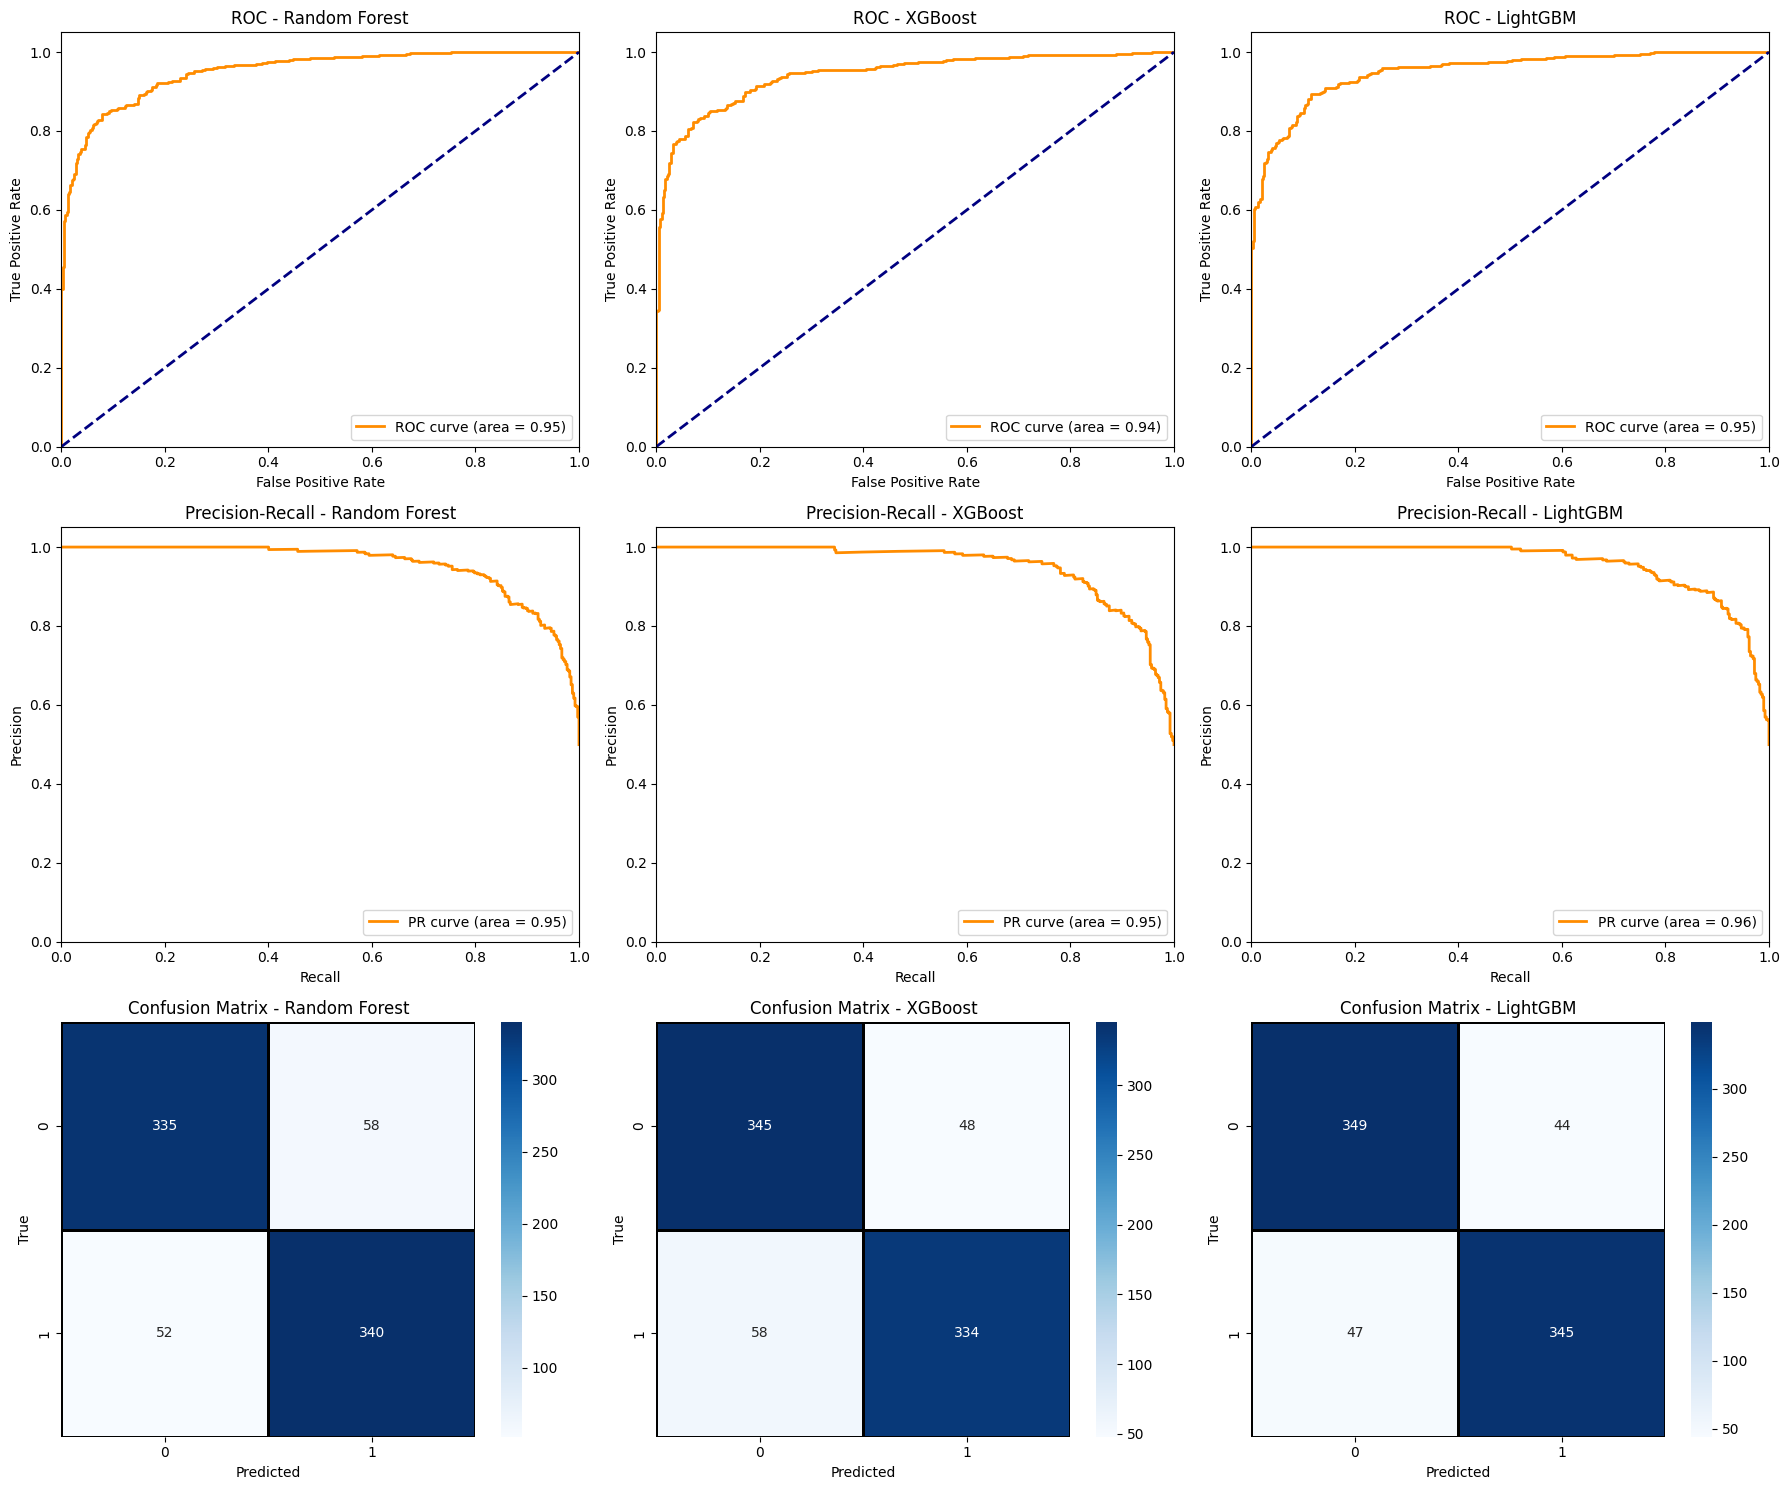

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8598726114649682, 'Precision': 0.8542713567839196, 'Recall': 0.8673469387755102, 'F1 Score': 0.8607594936708861, 'ROC AUC': 0.9498753699953264}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.8649681528662421, 'Precision': 0.8743455497382199, 'Recall': 0.8520408163265306, 'F1 Score': 0.8630490956072352, 'ROC AUC': 0.9413719686347821}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8840764331210191, 'Precision': 0.8868894601542416, 'Recall': 0.8801020408163265, 'F1 Score': 0.88348271446863, 'ROC AUC': 0.9498234408267123}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8840764331210191,
 'Precision': 0.8868894601542416,
 'Recall': 0.8801020408163265,
 'F1 Score': 0.88348271446863,
 'ROC AUC': 0.9498234408267123}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.8841


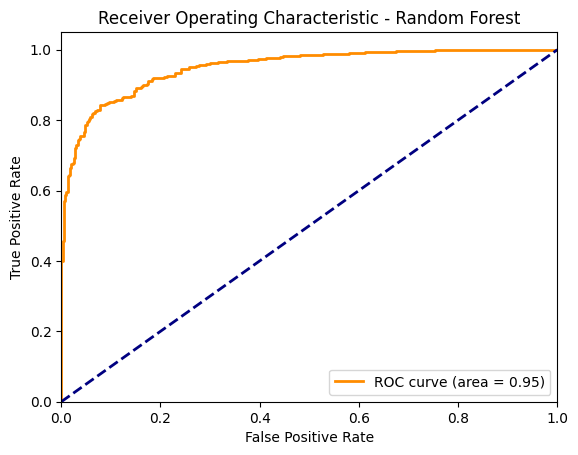

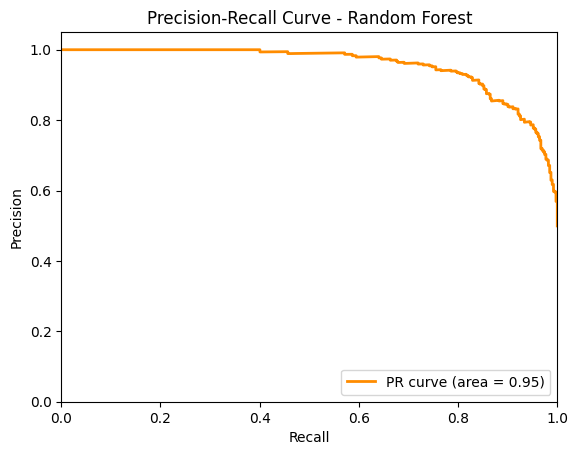

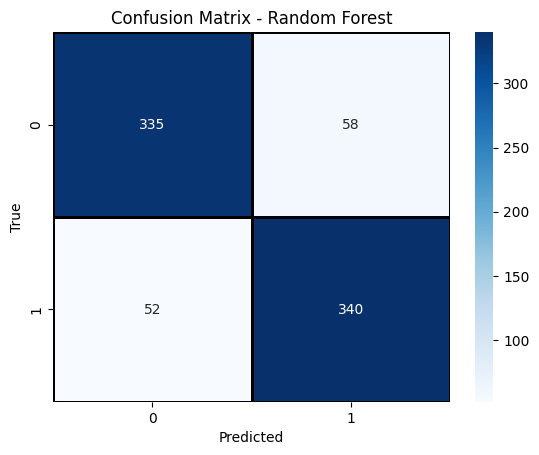

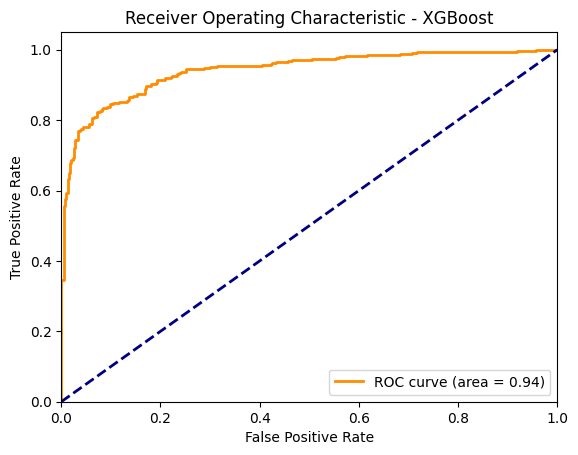

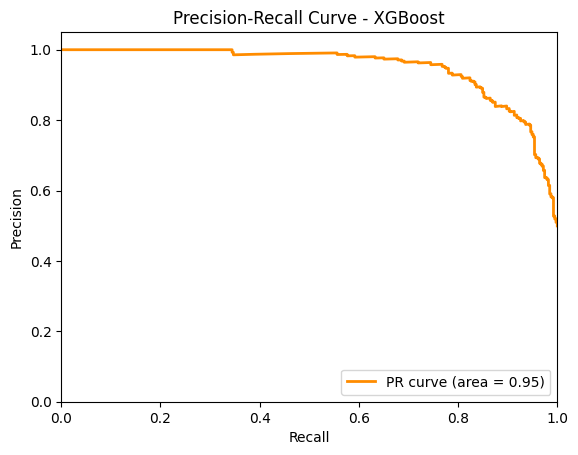

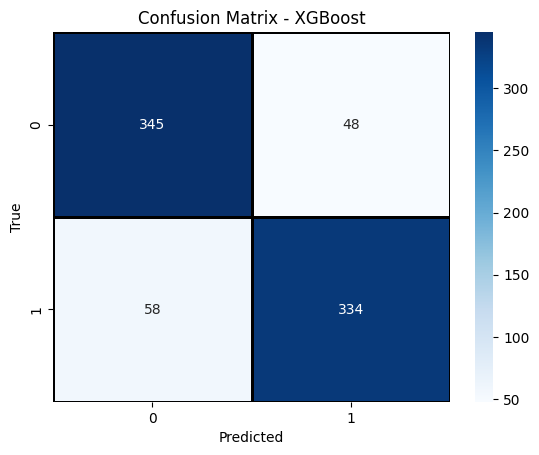

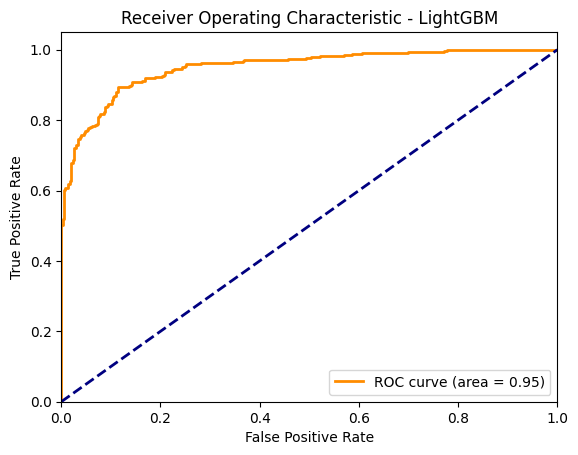

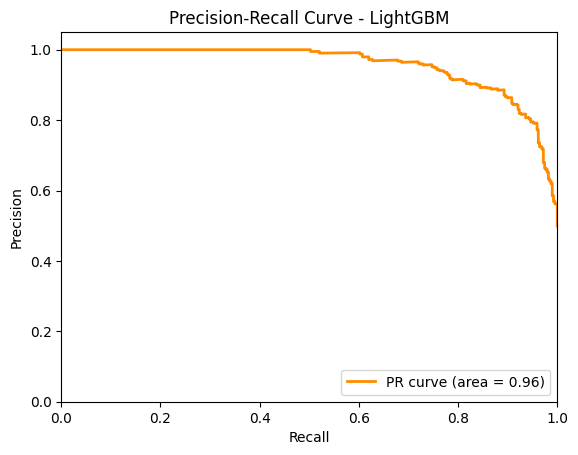

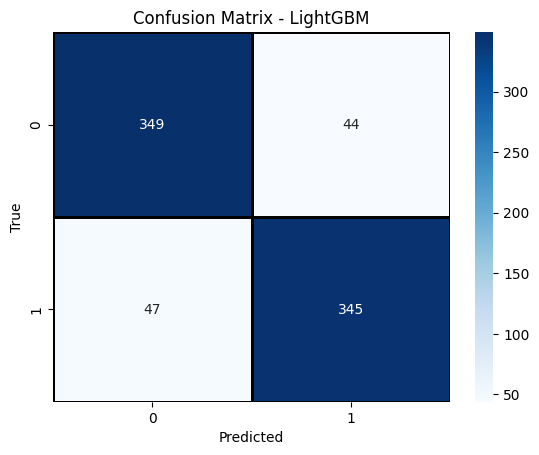

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

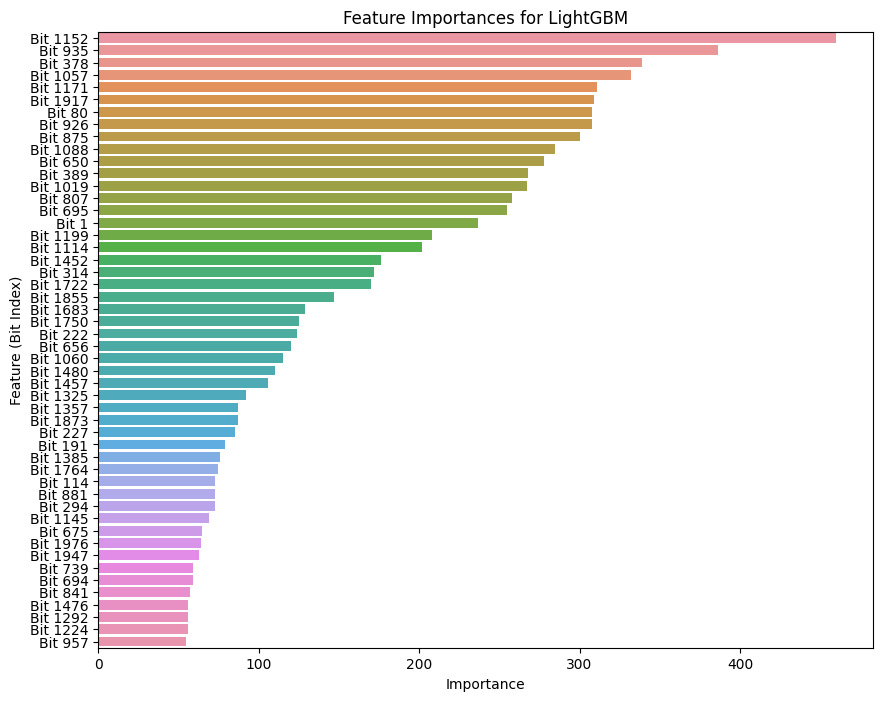

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
